In [211]:
import tensorflow as tf
# tf.enable_eager_execution()

from matplotlib import pyplot as plt
from os.path import join
import os
import numpy as np
import json

import seaborn as sns
import matplotlib.ticker as ticker
import pandas as pd

%matplotlib inline

In [2]:
# tf.executing_eagerly()

In [212]:
def get_tag_list(eventfile_path, print_process=False):
    value_list_dict = {}
    print_first_step = 0  
    # tag_set = set()
    try:
        for e in tf.train.summary_iterator(eventfile_path):
            if print_process:  # for debugging
                print(e)
            if print_first_step<5: # record the first step
                print("{}-th step:".format(print_first_step), e.step)
                print_first_step += 1
            for v in e.summary.value:
                if v.tag not in value_list_dict:
                    # tag_set.add(v.tag)
                    value_list_dict[v.tag] = []
                value_list_dict[v.tag].append(v.simple_value)
    except:
        print('some error occurred when reading tensorboard record data, return the already read value list')
        print('eventfile_path:', eventfile_path)
        return value_list_dict
    #print('all tag types:', tag_set)
    return value_list_dict  # , tag_set
    
    
def get_event_file_path(directory):
    for fn in os.listdir(directory):
        if fn.startswith('events.out.tfevents'):
            event_file_path = join(directory, fn)
            break
    return event_file_path


def get_var_list(tensorboard_dir, var_dir_dict, var_name, var_key=None, print_process=False):
    tb_event_path = get_event_file_path(join(tensorboard_dir, var_dir_dict[var_name]))
    var_list_dict = get_tag_list(tb_event_path, print_process=print_process)
    if var_key is None:
        var_list = var_list_dict[list(var_list_dict.keys())[0]]
    else:
        var_list = var_list_dict[var_key]
    return var_list

In [213]:
var_dir_dict = {'train_loss': 'Regularized_losses/Training/Total loss', 
                'train_root_loss': 'Regularized_losses/Training/Root loss', 
                'train_soil_loss': 'Regularized_losses/Training/Soil loss', 
                'val_loss': 'Regularized_losses/Validation/Total loss', 
                'val_root_loss': 'Regularized_losses/Validation/Root loss', 
                'val_soil_loss': 'Regularized_losses/Validation/Soil loss', 
                'validation_f_score': '',
                'num_tp': 'validation_f_score/number of tp, fp, fn, tn/num_tp', 
                'num_fp': 'validation_f_score/number of tp, fp, fn, tn/num_fp', 
                'num_fn': 'validation_f_score/number of tp, fp, fn, tn/num_fn', 
                'num_tn': 'validation_f_score/number of tp, fp, fn, tn/num_tn'
                }


def get_model_var_lists(model_name, model_dir, tb_sub_dir='runs'):
    tensorboard_dir = join(model_dir, model_name, tb_sub_dir)

    # print('getting train_loss')
    train_loss_l = get_var_list(tensorboard_dir, var_dir_dict, 'train_loss', var_key=None)
    # print('getting train_root_loss')
    train_root_loss_l = get_var_list(tensorboard_dir, var_dir_dict, 'train_root_loss', var_key=None)
    # print('getting train_soil_loss')
    train_soil_loss_l = get_var_list(tensorboard_dir, var_dir_dict, 'train_soil_loss', var_key=None)

    # print('getting val_loss')
    val_loss_l = get_var_list(tensorboard_dir, var_dir_dict, 'val_loss', var_key=None)
    # print('getting val_root_loss')
    val_root_loss_l = get_var_list(tensorboard_dir, var_dir_dict, 'val_root_loss', var_key=None)
    # print('getting val_soil_loss')
    val_soil_loss_l = get_var_list(tensorboard_dir, var_dir_dict, 'val_soil_loss', var_key=None)

    # print('getting num_tp')
    num_tp = get_var_list(tensorboard_dir, var_dir_dict, 'num_tp', var_key=None)
    # print('getting num_fp')
    num_fp = get_var_list(tensorboard_dir, var_dir_dict, 'num_fp', var_key=None)
    # print('getting num_fn')
    num_fn = get_var_list(tensorboard_dir, var_dir_dict, 'num_fn', var_key=None)
    # print('getting num_tn')
    num_tn = get_var_list(tensorboard_dir, var_dir_dict, 'num_tn', var_key=None)

    # print('getting validation_f_score')
    validation_f_score = get_var_list(tensorboard_dir, var_dir_dict, 'validation_f_score', var_key='validation_f_score', print_process=False)
    
    return train_loss_l, train_root_loss_l, train_soil_loss_l, \
           val_loss_l, val_root_loss_l, val_soil_loss_l, \
           num_tp, num_fp, num_fn, num_tn, \
           validation_f_score


def get_other_params_in_model(model_dir, model_name):
    with open(join(model_dir, model_name, 'model_arguments.txt'), 'r') as f:
        f_str = f.read().replace('<br>', '')
        model_arguments = json.loads(f_str)
    train_loss_reporting_interval = model_arguments['train_loss_reporting_interval']
    val_interval = model_arguments['val_interval']
    batch_size = model_arguments['batch_size']
    total_train_data_num = model_arguments['train_length'] + model_arguments['train_combining_length']
    batch_num_epoch = total_train_data_num / batch_size

    # print(json.dumps(model_arguments, indent=2))
    print('train_loss_reporting_interval:', train_loss_reporting_interval)
    print('val_interval:', val_interval)
    print('batch_size:', batch_size)
    print('batch_num_epoch:', batch_num_epoch)
    
    return train_loss_reporting_interval, val_interval, batch_size, total_train_data_num, batch_num_epoch


In [164]:
# path = '/home/stud/zhaoy/local_dir/model_outputs_yi/3DUNet_noPadding_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:20000_nl:0_nh:0_nd:1_ng:1_bs:18_mg_0.01_csl_60_apa_id_10_07_19_3DUNet_trainOnCombinedCropOnly_randomScaling_uniformSampling_lr0.0001_planeFreq0.5/runs/Regularized_losses/Training/Total loss/events.out.tfevents.1562788199.bigcuda4'
# value_list_dict = get_tag_list(path)
# print('all tag types:', list(value_list_dict.keys()))


wall_time: 1562788199.8575041

wall_time: 1562788199.8555245
summary {
  value {
    tag: "Regularized_losses/Training"
    simple_value: 0.7126746773719788
  }
}

wall_time: 1562788442.5020666
step: 1
summary {
  value {
    tag: "Regularized_losses/Training"
    simple_value: 0.7066953182220459
  }
}

wall_time: 1562788688.9908113
step: 2
summary {
  value {
    tag: "Regularized_losses/Training"
    simple_value: 0.7015503644943237
  }
}

wall_time: 1562788931.5133197
step: 3
summary {
  value {
    tag: "Regularized_losses/Training"
    simple_value: 0.6964059472084045
  }
}

wall_time: 1562789177.255466
step: 4
summary {
  value {
    tag: "Regularized_losses/Training"
    simple_value: 0.6919923424720764
  }
}

wall_time: 1562789760.432349
step: 5
summary {
  value {
    tag: "Regularized_losses/Training"
    simple_value: 0.6884860396385193
  }
}

wall_time: 1562790001.9347296
step: 6
summary {
  value {
    tag: "Regularized_losses/Training"
    simple_value: 0.6837578415870667

wall_time: 1563025428.939924
step: 741
summary {
  value {
    tag: "Regularized_losses/Training"
    simple_value: 0.0026331888511776924
  }
}

wall_time: 1563025670.9946535
step: 742
summary {
  value {
    tag: "Regularized_losses/Training"
    simple_value: 0.0038828784599900246
  }
}

wall_time: 1563025905.7155766
step: 743
summary {
  value {
    tag: "Regularized_losses/Training"
    simple_value: 0.002160007134079933
  }
}

wall_time: 1563026146.6271017
step: 744
summary {
  value {
    tag: "Regularized_losses/Training"
    simple_value: 0.0014247625367715955
  }
}

wall_time: 1563026740.5763562
step: 745
summary {
  value {
    tag: "Regularized_losses/Training"
    simple_value: 0.0027441582642495632
  }
}

wall_time: 1563026980.3476253
step: 746
summary {
  value {
    tag: "Regularized_losses/Training"
    simple_value: 0.0023444113321602345
  }
}

wall_time: 1563027228.0609708
step: 747
summary {
  value {
    tag: "Regularized_losses/Training"
    simple_value: 0.0026980

# Get the lists of variables for plotting

In [204]:
# model_name = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:25_csl_60_id_21_10_19_3DUNet_trainOnBothCombinedAndNonCombined_realSoilOnly_validateOnCrops_fixedCropTrain_uniSamp_lr1e-4'
model_name = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:25_csl_60_id_24_10_19_3DUNet_trainOnBothCombinedAndNonCombined_realSoilOnly_validateOnCrops_fixedCropTrain_shuffleCrops_uniSamp_lr1e-4'
# model_name = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_28_10_19_3DUNet_trainOnBothCombinedAndNonCombined_realSoilOnly_validateOnCrops_fixedCropTrain_shuffleCrops_earlierTimeOnly'

model_dir = '/home/user/zhaoy/local_dir/model_outputs_yi/mount_remote/bigcuda4'  # bigcuda4
# model_dir = '/home/user/zhaoy/local_dir/model_outputs_yi/mount_remote/cuda12'  # cuda12
# model_dir = '/home/user/zhaoy/local_dir/model_outputs_yi/mount_remote/cuda4'  # cuda4

train_loss_l, train_root_loss_l, train_soil_loss_l, \
val_loss_l, val_root_loss_l, val_soil_loss_l, \
num_tp, num_fp, num_fn, num_tn, \
validation_f_score = get_model_var_lists(model_name, model_dir)

# get mini-batch size, train/val loss reporting interval (batches) of the current model

train_loss_reporting_interval, val_interval, batch_size, \
total_train_data_num, batch_num_epoch = get_other_params_in_model(model_dir, model_name)

0-th step: 0
1-th step: 0
2-th step: 1
3-th step: 2
4-th step: 3
0-th step: 0
1-th step: 0
2-th step: 1
3-th step: 2
4-th step: 3
0-th step: 0
1-th step: 0
2-th step: 1
3-th step: 2
4-th step: 3
0-th step: 0
1-th step: 0
2-th step: 200
3-th step: 400
4-th step: 600
0-th step: 0
1-th step: 0
2-th step: 200
3-th step: 400
4-th step: 600
0-th step: 0
1-th step: 0
2-th step: 200
3-th step: 400
4-th step: 600
0-th step: 0
1-th step: 0
2-th step: 200
3-th step: 400
4-th step: 600
0-th step: 0
1-th step: 0
2-th step: 200
3-th step: 400
4-th step: 600
0-th step: 0
1-th step: 0
2-th step: 200
3-th step: 400
4-th step: 600
0-th step: 0
1-th step: 0
2-th step: 200
3-th step: 400
4-th step: 600
0-th step: 0
1-th step: 0
2-th step: 0
3-th step: 0
4-th step: 0
train_loss_reporting_interval: 1
val_interval: 200
batch_size: 25
batch_num_epoch: 4000.0


In [187]:
max(validation_f_score2)

0.9669086337089539

In [220]:
# model_name2 = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:25_csl_60_id_22_10_19_3DUNet_trainOnNonCombinedOnly_validateOnCrops_notFixedCropTrain_uniSamp_lr1e-4'
# model_name2 = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:25_csl_60_id_24_10_19_3DUNet_trainOnBothCombinedAndNonCombined_realSoilOnly_validateOnCrops_fixedCropTrain_shuffleCrops_importanceSamp'
# model_name2 = 'UNet_3D_noPadding_BNbeforeReLU_addOneNewChannel_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_31_10_19_3DUNet_trainOnCombinedAndNonCombined_realSoil_valOnCrops_fixedCropTrain_shuffleCrops_uniSamp_distToCenterAxis'
# model_name2 = 'UNet_3D_noPadding_BNbeforeReLU_addLaterTimePoint_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_29_10_19_3DUNet_trainOnCombinedAndNonCombined_realSoil_valOnCrops_fixedCropTrain_shuffleCrops_earlierPlusLaterTime'
# model_name2 = 'UNet_3D_noPadding_BNbeforeReLU_addOneNewChannel_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_03_11_19_3DUNet_trainOnCombinedAndNonCombined_realSoil_valCrops_shuffledFixedCropTrain_uniSamp_depthArray_zFlipCorrect'
# model_name2 = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_15_11_19_3DUNet_trainOnCombinedAndNot_realSoil_valOnCrops_fixedCropTrainShuffled_uniSamp_gradientDiffLossWeight10_lossRecording'
model_name2 = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_22_11_19_3DUNet_trainOnCombinedAndNot_realSoil_valOnCrops_fixedCropTrainShuffled_uniSamp_gradientDiffLoss_LOGweight1'

# model_dir2 = '/home/user/zhaoy/local_dir/model_outputs_yi/mount_remote/bigcuda4'  # bigcuda4
# model_dir2 = '/home/user/zhaoy/local_dir/model_outputs_yi/mount_remote/cuda12'  # cuda12
model_dir2 = '/home/user/zhaoy/local_dir/model_outputs_yi/mount_remote/cuda4'  # cuda4

train_loss_l2, train_root_loss_l2, train_soil_loss_l2, \
val_loss_l2, val_root_loss_l2, val_soil_loss_l2, \
num_tp2, num_fp2, num_fn2, num_tn2, \
validation_f_score2 = get_model_var_lists(model_name2, model_dir2)

# get mini-batch size, train/val loss reporting interval (batches) of the current model
train_loss_reporting_interval2, val_interval2, batch_size2, \
total_train_data_num2, batch_num_epoch2 = get_other_params_in_model(model_dir2, model_name2)

0-th step: 0
1-th step: 0
2-th step: 1
3-th step: 2
4-th step: 3
0-th step: 0
1-th step: 0
2-th step: 1
3-th step: 2
4-th step: 3
0-th step: 0
1-th step: 0
2-th step: 1
3-th step: 2
4-th step: 3
0-th step: 0
1-th step: 0
2-th step: 200
3-th step: 400
4-th step: 600
0-th step: 0
1-th step: 0
2-th step: 200
3-th step: 400
4-th step: 600
0-th step: 0
1-th step: 0
2-th step: 200
3-th step: 400
4-th step: 600
0-th step: 0
1-th step: 0
2-th step: 200
3-th step: 400
4-th step: 600
0-th step: 0
1-th step: 0
2-th step: 200
3-th step: 400
4-th step: 600
0-th step: 0
1-th step: 0
2-th step: 200
3-th step: 400
4-th step: 600
0-th step: 0
1-th step: 0
2-th step: 200
3-th step: 400
4-th step: 600
0-th step: 0
1-th step: 0
2-th step: 0
3-th step: 0
4-th step: 0
some error occurred when reading tensorboard record data, return the already read value list
eventfile_path: /home/user/zhaoy/local_dir/model_outputs_yi/mount_remote/cuda4/UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_n

## Special: for connecting 2 sequential training recordings

In [189]:

model_name2 = 'UNet_3D_noPadding_BNbeforeReLU_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:25_csl_60_id_25_10_19_3DUNet_trainOnBothCombinedAndNonCombined_realSoilOnly_validateOnCrops_fixedCropTrain_shuffleCrops_uniSamp_dontCare'
# model_name2 = 'UNet_3D_noPadding_BNbeforeReLU_addOneNewChannel_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_03_11_19_3DUNet_trainOnCombinedAndNonCombined_realSoil_valCrops_shuffledFixedCropTrain_uniSamp_distToCenterAxis_zflipCorrect'
# model_name2 = 'UNet_3D_noPadding_BNbeforeReLU_rw:x10.0_l2:0.0_lr:0.0001->0.01_tts:100_nl:0_nh:0_nd:1_ng:1_bs:16_gi_2_csl_60_id_05_11_19_3DUNet_trainOnCombinedAndNonCombined_realSoil_valCrops_fixCropTrain_shuffleCrops_uniSamp_rootWeight10'

model_dir2 = '/home/user/zhaoy/local_dir/model_outputs_yi/mount_remote/bigcuda4'  # bigcuda4
# model_dir2 = '/home/user/zhaoy/local_dir/model_outputs_yi/mount_remote/cuda12'  # cuda12
# model_dir2 = '/home/user/zhaoy/local_dir/model_outputs_yi/mount_remote/cuda4'  # cuda4

# part 0
train_loss_l2_0, train_root_loss_l2_0, train_soil_loss_l2_0, \
val_loss_l2_0, val_root_loss_l2_0, val_soil_loss_l2_0, \
num_tp2_0, num_fp2_0, num_fn2_0, num_tn2_0, \
validation_f_score2_0 = get_model_var_lists(model_name2, model_dir2, tb_sub_dir='runs_1thRun')

# part 1
train_loss_l2_1, train_root_loss_l2_1, train_soil_loss_l2_1, \
val_loss_l2_1, val_root_loss_l2_1, val_soil_loss_l2_1, \
num_tp2_1, num_fp2_1, num_fn2_1, num_tn2_1, \
validation_f_score2_1 = get_model_var_lists(model_name2, model_dir2, tb_sub_dir='runs')



0-th step: 0
1-th step: 0
2-th step: 1
3-th step: 2
4-th step: 3
0-th step: 0
1-th step: 0
2-th step: 1
3-th step: 2
4-th step: 3
0-th step: 0
1-th step: 0
2-th step: 1
3-th step: 2
4-th step: 3
0-th step: 0
1-th step: 0
2-th step: 400
3-th step: 800
4-th step: 1200
0-th step: 0
1-th step: 0
2-th step: 400
3-th step: 800
4-th step: 1200
0-th step: 0
1-th step: 0
2-th step: 400
3-th step: 800
4-th step: 1200
0-th step: 0
1-th step: 0
2-th step: 400
3-th step: 800
4-th step: 1200
0-th step: 0
1-th step: 0
2-th step: 400
3-th step: 800
4-th step: 1200
0-th step: 0
1-th step: 0
2-th step: 400
3-th step: 800
4-th step: 1200
0-th step: 0
1-th step: 0
2-th step: 400
3-th step: 800
4-th step: 1200
0-th step: 0
1-th step: 0
2-th step: 0
3-th step: 0
4-th step: 0
0-th step: 0
1-th step: 24000
2-th step: 24001
3-th step: 24002
4-th step: 24003
0-th step: 0
1-th step: 24000
2-th step: 24001
3-th step: 24002
4-th step: 24003
0-th step: 0
1-th step: 24000
2-th step: 24001
3-th step: 24002
4-th step:

In [190]:
print(len(train_loss_l2_0))
print(len(train_root_loss_l2_0))
print(len(train_soil_loss_l2_0))
print(len(val_loss_l2_0))
print(len(val_root_loss_l2_0))
print(len(val_soil_loss_l2_0))
print(len(num_tp2_0))
print(len(num_fp2_0))
print(len(num_fn2_0))
print(len(num_tn2_0))
print(len(validation_f_score2_1))


24400
24400
24400
61
61
61
61
61
61
61
69


In [191]:
# get mini-batch size, train/val loss reporting interval (batches) of the current model
train_loss_reporting_interval2, val_interval2, batch_size2, \
total_train_data_num2, batch_num_epoch2 = get_other_params_in_model(model_dir2, model_name2)

train_loss_reporting_interval: 1
val_interval: 400
batch_size: 25
batch_num_epoch: 4000.0


In [192]:
# only works when the num_batch_in_epoch%num_batch_val == 0
train_cut_position = 24000  # 37500 for model distToCenterAxis_zflipCorrect, 50000 for uniSamp_rootWeight10
val_cut_position = train_cut_position//val_interval2
print('val_cut_position:', val_cut_position)
assert train_cut_position%val_interval2 == 0

# combine part 0, 1
train_loss_l2 = train_loss_l2_0[:train_cut_position] + train_loss_l2_1
train_root_loss_l2 = train_root_loss_l2_0[:train_cut_position] + train_root_loss_l2_1
train_soil_loss_l2 = train_soil_loss_l2_0[:train_cut_position] + train_soil_loss_l2_1

val_loss_l2 = val_loss_l2_0[:val_cut_position] + val_loss_l2_1
val_root_loss_l2 = val_root_loss_l2_0[:val_cut_position] +val_root_loss_l2_1
val_soil_loss_l2 = val_soil_loss_l2_0[:val_cut_position] + val_soil_loss_l2_1

num_tp2 = num_tp2_0[:val_cut_position] + num_tp2_1
num_fp2 = num_fp2_0[:val_cut_position] + num_fp2_1
num_fn2 = num_fn2_0[:val_cut_position] + num_fn2_1
num_tn2 = num_tn2_0[:val_cut_position] + num_tn2_1

validation_f_score2 = validation_f_score2_0[:val_cut_position] + validation_f_score2_1




val_cut_position: 60


In [193]:
def plot_var_lists(var_list_list, var_name_list, record_step_size_list, epoch_data_num_list=None, title=None, ylimit=None, y_label='value', fig_name=None):

    fig = plt.figure(dpi=120)
    sns.set_context("notebook", font_scale=1.3)
    # sns.set_context("talk")
    # sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    # sns.set_style("ticks")
    # sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
    sns.set_style('darkgrid', {'font.family':'sans-serif', 'font.sans-serif':'Arial'})
    
    if epoch_data_num_list is not None:
        dict_plot = {'batch':[], y_label:[], 'epoch':[], '':[]}
    else:
        dict_plot = {'batch':[], y_label:[], '':[]}
    for i in range(len(var_name_list)): 
        var_name = var_name_list[i]
        var_list = var_list_list[i]
        dict_plot[y_label].extend(var_list)
        dict_plot[''].extend([var_name for _ in range(len(var_list))])
        record_step_size = record_step_size_list[i]
        _x = np.arange(0, record_step_size*len(var_list), record_step_size)
        dict_plot['batch'].extend(_x)
        if epoch_data_num_list is not None:
            epoch_data_num = epoch_data_num_list[i]
            _e = _x / epoch_data_num
            dict_plot['epoch'].extend(_e)
        
    print('len(dict_plot[y_label]):', len(dict_plot[y_label]))
    print('len(dict_plot["batch"]):', len(dict_plot['batch']))
    print('len(dict_plot[" "]):', len(dict_plot['']))

    
    df = pd.DataFrame(data=dict_plot)
    if epoch_data_num_list is None:
        ax = sns.relplot(x='batch', y=y_label, hue='', data=df, kind="line", aspect=1.5)
    else:
        ax = sns.relplot(x='epoch', y=y_label, hue='', data=df, kind="line", aspect=1.5)
    # ax.fig.autofmt_xdate()
    
    # adjust legend location
    leg = ax._legend
    leg.set_bbox_to_anchor([1,0.5])
#     leg.set_bbox_to_anchor([0.8,0.88])
    
    ax0 = plt.gca()
    ax0.xaxis.set_major_formatter(ticker.EngFormatter())
    
    plt.ylim(ylimit)
    for l in ax.ax.lines:
        print(l.get_linewidth())
        plt.setp(l,linewidth=1.5)  # 2
        
    plt.title(title, pad=-20)
    
    if fig_name is not None:
        plt.savefig(join('thesis_figures', fig_name), dpi=fig.dpi)
    plt.show()
    
    
def generate_df_for_plot(var_list_list, var_name_list, record_step_size_list, epoch_data_num_list=None, 
                         x_label='batch', y_label='value', legend_name=''):
    if epoch_data_num_list is not None:
        dict_plot = {x_label:[], y_label:[], legend_name:[]}
    else:
        dict_plot = {x_label:[], y_label:[], legend_name:[]}
    for i in range(len(var_name_list)): 
        var_name = var_name_list[i]
        var_list = var_list_list[i]
        dict_plot[y_label].extend(var_list)
        dict_plot[legend_name].extend([var_name for _ in range(len(var_list))])
        record_step_size = record_step_size_list[i]
        _x = np.arange(0, record_step_size*len(var_list), record_step_size)
        dict_plot[x_label].extend(_x)
    
    df = pd.DataFrame(data=dict_plot)
    return df

# Generate plots for thesis

In [270]:
train_loss_l, train_root_loss_l, train_soil_loss_l, \
val_loss_l, val_root_loss_l, val_soil_loss_l, \
num_tp, num_fp, num_fn, num_tn, \
validation_f_score

717 387


### Apply smoothing

In [194]:
def smooth_list(l, smooth_weight=0.5):
    smoothed_l = [l[0]]
    for i in range(1, len(l)):
        smoothed_l.append(smooth_weight*smoothed_l[i-1]+(1-smooth_weight)*l[i])
    return smoothed_l

In [195]:
val_loss_l_smoothed = smooth_list(val_loss_l, smooth_weight=0.85)
val_loss_l2_smoothed = smooth_list(val_loss_l2, smooth_weight=0.85)

# validation_f_score_smoothed = smooth_list(validation_f_score, smooth_weight=0.85)
# validation_f_score2_smoothed = smooth_list(validation_f_score2, smooth_weight=0.85)

# val_root_loss_l_smoothed = smooth_list(val_root_loss_l, smooth_weight=0.8)
# val_root_loss_l2_smoothed = smooth_list(val_root_loss_l2, smooth_weight=0.8)

# val_soil_loss_l_smoothed = smooth_list(val_soil_loss_l, smooth_weight=0.8)
# val_soil_loss_l2_smoothed = smooth_list(val_soil_loss_l2, smooth_weight=0.8)

In [196]:
# manually generate the dataframe for plotting for smoothing

var_list_list = [val_loss_l, val_loss_l2]  # [val_loss_l, val_loss_l2], [validation_f_score, validation_f_score2]  # [:548]
var_list_list_smoothed = [val_loss_l_smoothed, val_loss_l2_smoothed]  # [val_loss_l_smoothed, val_loss_l2_smoothed], [validation_f_score_smoothed, validation_f_score2_smoothed]  # [:548]
var_name_list = ['without', 'with']   # ['uniform sampling', 'importance sampling'], ['without', 'with'], ['1    .', '10  .']
record_step_size_list = [val_interval*batch_size/batch_size2, val_interval2]  # [val_interval, val_interval2], [val_interval*batch_size/batch_size2, val_interval2], only when batchsizes are slightly different
legend_name='dont care mask'  # 'Later time point', 'Voxel depth info', 'Distance to central axis', 'Root weight'
y_name = '    '  # Validation root loss

dict_plot = {'batch':[], y_name:[], ' ':[], legend_name:[]}
for i in range(len(var_name_list)): 
    var_name = var_name_list[i]
    var_list = var_list_list[i]
    var_list_smoothed = var_list_list_smoothed[i]
    record_step_size = record_step_size_list[i]
    _x = np.arange(0, record_step_size*len(var_list), record_step_size)
    
    dict_plot[y_name].extend(var_list_smoothed)
    dict_plot[legend_name].extend([var_name for _ in range(len(var_list))])
    dict_plot[' '].extend(['smoothed' for _ in range(len(var_list))])
    dict_plot['batch'].extend(_x)
    
    dict_plot[y_name].extend(var_list)
    dict_plot[legend_name].extend([var_name for _ in range(len(var_list))])
    dict_plot[' '].extend(['original' for _ in range(len(var_list))])
    dict_plot['batch'].extend(_x)
    
    
    
df = pd.DataFrame(data=dict_plot)
# df[legend_name] = df[legend_name].astype('category')
# df[legend_name].dtype


<Figure size 720x480 with 0 Axes>

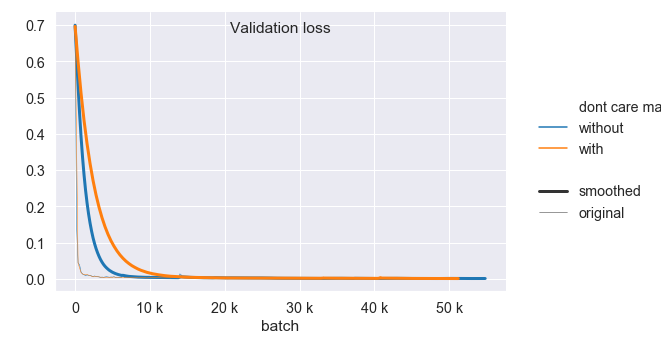

In [198]:
fig = plt.figure(dpi=120)
sns.set_context("notebook", font_scale=1.3)
# sns.set_context("talk")
# sns.set_style("darkgrid", {"axes.facecolor": ".9"})
# sns.set_style("ticks")
# sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_style('darkgrid', {'font.family':'sans-serif', 'font.sans-serif':'Arial'})

ax = sns.relplot(x='batch', y=y_name, hue=legend_name, 
                 size=' ', sizes=(0.5,3), data=df, kind="line", aspect=1.5)

# adjust legend location
leg = ax._legend
leg.set_bbox_to_anchor([1,0.5])
#     leg.set_bbox_to_anchor([0.8,0.88])

ax0 = plt.gca()
ax0.xaxis.set_major_formatter(ticker.EngFormatter())

# plt.ylim((0,0.0045))
# plt.ylim((0,0.02))
# plt.ylim((0.6,1.04))

# i=0
# for l in ax.ax.lines:
#     if i%2!=0:
#         print(l.get_linewidth())
#         plt.setp(l,linewidth=4)  # 2
#     i += 1

plt.title('Validation loss', pad=-20)

# plt.savefig(join('thesis_figures', 'rootWeight_1vs10_val_soil_loss'), dpi=fig.dpi)
plt.show()


### No smoothing

In [ ]:
train_loss_l, train_root_loss_l, train_soil_loss_l, \
val_loss_l, val_root_loss_l, val_soil_loss_l, \
num_tp, num_fp, num_fn, num_tn, \
validation_f_score

In [205]:
x_label='batch'
y_label= 'Validation loss'  # 'Validation loss', 'Validation F1 score'
legend_name= 'gradient difference loss' # 'Later time point': [:548], 'Voxel depth info', 'Distance to central axis', 'dont care flag'

# dilute_ratio = 250
# train_root_loss_l_sparse=list(np.array(train_root_loss_l)[::dilute_ratio])
# train_root_loss_l2_sparse=list(np.array(train_root_loss_l2)[::dilute_ratio])

df = generate_df_for_plot([validation_f_score, validation_f_score2], ['without', 'with'], 
                          # [1*dilute_ratio, 1*dilute_ratio],
                          [val_interval*batch_size/batch_size2, val_interval2], 
                          # [val_interval*batch_size, val_interval2*batch_size2],
                          x_label=x_label, y_label=y_label, legend_name =legend_name,
                          epoch_data_num_list=None)



<Figure size 720x480 with 0 Axes>

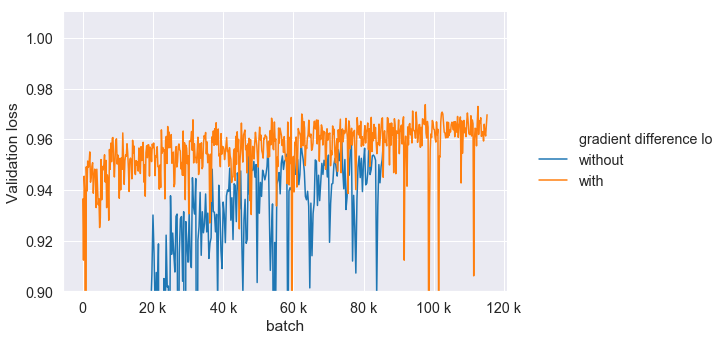

In [208]:
fig = plt.figure(dpi=120)
sns.set_context("notebook", font_scale=1.3)
# sns.set_context("talk")
# sns.set_style("darkgrid", {"axes.facecolor": ".9"})
# sns.set_style("ticks")
# sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_style('darkgrid', {'font.family':'sans-serif', 'font.sans-serif':'Arial'})

ax = sns.relplot(x=x_label, y=y_label, hue=legend_name, data=df, kind="line", aspect=1.5)

# adjust legend location
leg = ax._legend
leg.set_bbox_to_anchor([1,0.5])
#     leg.set_bbox_to_anchor([0.8,0.88])

ax0 = plt.gca()
ax0.xaxis.set_major_formatter(ticker.EngFormatter())

plt.ylim((0.9,1.01))

# for l in ax.ax.lines:
#     print(l.get_linewidth())
#     plt.setp(l,linewidth=1.5)  # 2

# plt.title('', pad=-20)

# plt.savefig(join('thesis_figures', 'multi_timepoints_val_f1'), dpi=fig.dpi)
plt.show()


In [221]:
# def find_idx_with_highest_valF(validation_f_score, batch_num_epoch, val_interval):
#     # find the saved model with highest val F score
#     i = 0
#     saved_model_val_list = []
#     while i<len(validation_f_score):
#         saved_model_val_list.append(validation_f_score[int(i)])  # approximation
#         i += batch_num_epoch / val_interval

#     print(saved_model_val_list)
#     print('total length of val list:', len(saved_model_val_list))
#     print(max(saved_model_val_list))
#     print('the number in the model name with highest val f score:', saved_model_val_list.index(max(saved_model_val_list))-1)
#     print()
    
    
def find_idx_with_highest_valF(validation_f_score, batch_num_epoch, val_interval):
    # find the saved model with highest val F score
    i = 0
    saved_model_val_list = []
    while i<len(validation_f_score):
        saved_model_val_list.append(validation_f_score[int(i)])  # really saved model
        i += batch_num_epoch / val_interval
        m = 1
        while int(i) != i:
            i += batch_num_epoch / val_interval
            m += 1
            print('m:', m)

    print(saved_model_val_list)
    print('total length of val list:', len(saved_model_val_list))
    print(max(saved_model_val_list))
    print('the number in the model name with highest val f score:', m*saved_model_val_list.index(max(saved_model_val_list))-1)
    

In [222]:
find_idx_with_highest_valF(validation_f_score2, batch_num_epoch2, val_interval2)


m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
m: 2
m: 3
m: 4
[0.007242126390337944, 0.9237909317016602, 0.9414576888084412, 0.9558843970298767, 0.9543951749801636, 0.9614371061325073, 0.9544923901557922, 0.9680440425872803, 0.9653041958808899, 0.959492564201355, 0.9669622182846069, 0.9653001427650452, 0.963331401348114, 0.9642032980918884, 0.9704567790031433, 0.9659401774406433, 0.9699333310127258, 0.9669485688209534, 0.970802366733551, 0.9681153893470764, 0.9679033756256104, 0.9683784246444702, 0.9673853516578674, 0.9713987708091736]
total length of val list: 24
0.9713987708091736
the number in the model name with highest val f score: 91


In [156]:
find_idx_with_highest_valF(validation_f_score, batch_num_epoch, val_interval)


[0.009075437672436237, 0.0, 0.83539217710495, 0.8517960906028748, 0.9376804232597351, 0.9448273777961731, 0.9312217831611633, 0.9275023937225342, 0.94895339012146, 0.9384490251541138, 0.9547277092933655, 0.9517185688018799, 0.932273268699646, 0.947484016418457]
total length of val list: 14
0.9547277092933655
the number in the model name with highest val f score: 9


In [42]:
max(validation_f_score2)

0.9637506604194641

In [386]:
find_idx_with_highest_valF(validation_f_score2, batch_num_epoch2, val_interval2)


[0.0025780636351555586, 0.9127952456474304, 0.9102170467376709, 0.9522938132286072]
total length of val list: 4
0.9522938132286072
the number in the model name with highest val f score: 11
m: 4


In [373]:
max(validation_f_score2)

0.9727215766906738

## Previous drafts

len(dict_plot[y_label]): 802
len(dict_plot["batch"]): 802
len(dict_plot[" "]): 802
1.5
1.5
0.0
1.5
1.5


<Figure size 768x576 with 0 Axes>

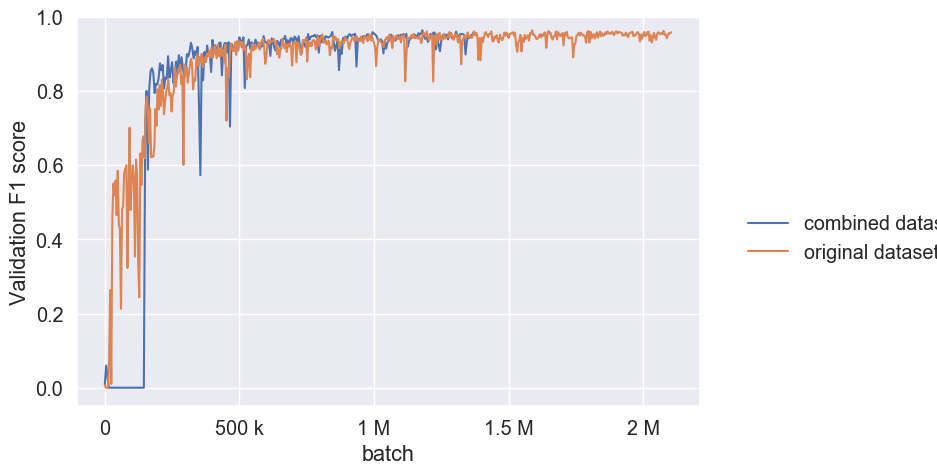

In [188]:

# plot the chosen variables in the same plot
plot_var_lists([validation_f_score, validation_f_score2], ['combined dataset', 'original dataset'], 
               [val_interval*batch_size, val_interval2*batch_size2],
#                [total_train_data_num, total_train_data_num2],
               title=None, ylimit=(-0.05,1), y_label='Validation F1 score')
# leg.set_bbox_to_anchor([0.72,0.27])

len(dict_plot[y_label]): 2136
len(dict_plot["batch"]): 2136
len(dict_plot[" "]): 2136
1.5
1.5
0.0
1.5
1.5


<Figure size 768x576 with 0 Axes>

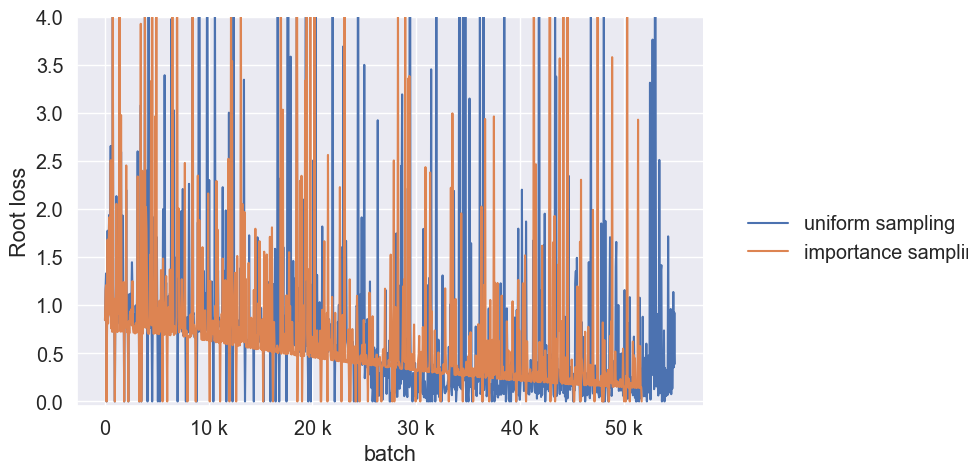

In [178]:
# train root loss
dilute_ratio = 50
train_root_loss_l_sparse=list(np.array(train_root_loss_l)[::dilute_ratio])
train_root_loss_l2_sparse=list(np.array(train_root_loss_l2)[::dilute_ratio])

# plot the chosen variables in the same plot
plot_var_lists([train_root_loss_l_sparse, train_root_loss_l2_sparse], ['uniform sampling', 'importance sampling'], 
               [1*dilute_ratio, 1*dilute_ratio],
#                [total_train_data_num, total_train_data_num2],
               title=None, ylimit=(-0.05,4), y_label='Root loss')

In [112]:
print(len(val_root_loss_l))
print(len(val_root_loss_l2))

275
174


len(dict_plot[y_label]): 405
len(dict_plot["batch"]): 405
len(dict_plot[" "]): 405
1.5
1.5
0.0
1.5
1.5


<Figure size 768x576 with 0 Axes>

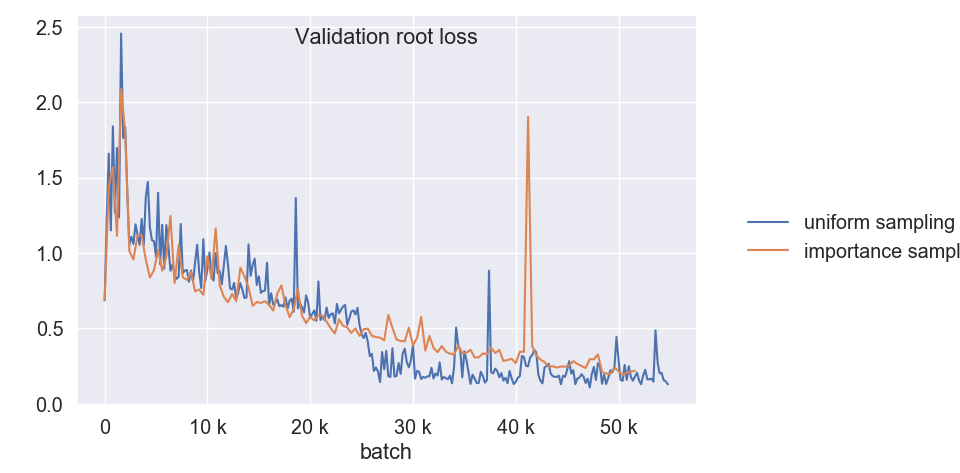

In [181]:
# val root loss

# plot the chosen variables in the same plot
plot_var_lists([val_root_loss_l, val_root_loss_l2], ['uniform sampling', 'importance sampling'], 
               [val_interval, val_interval2],
#                [total_train_data_num, total_train_data_num2],
               title='Validation root loss', ylimit=None, y_label=' ')  #, fig_name='us_VS_is_val_root_loss')

len(dict_plot[y_label]): 405
len(dict_plot["batch"]): 405
len(dict_plot[" "]): 405
1.5
1.5
0.0
1.5
1.5


<Figure size 768x576 with 0 Axes>

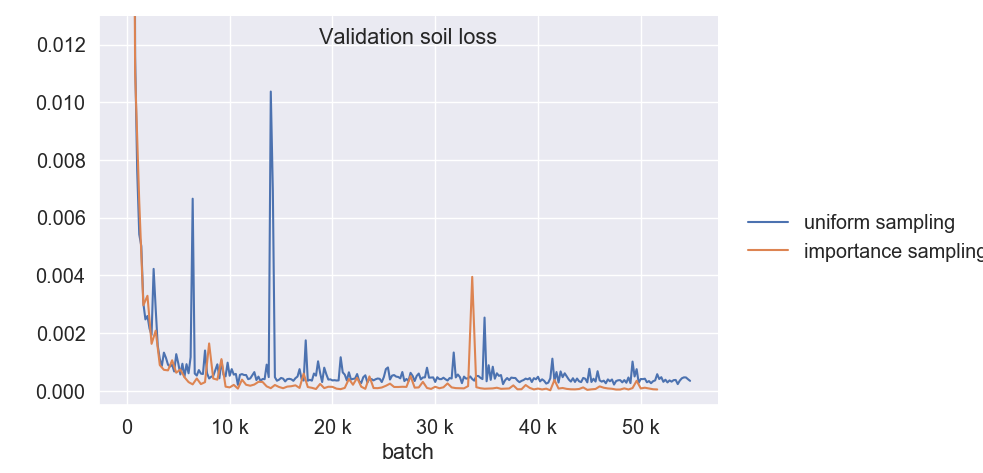

In [184]:
# val root loss

# plot the chosen variables in the same plot
plot_var_lists([val_soil_loss_l, val_soil_loss_l2], ['uniform sampling', 'importance sampling'], 
               [val_interval, val_interval2],
#                [total_train_data_num, total_train_data_num2],
               title='Validation soil loss', ylimit=(-0.0005, 0.013), y_label=' ')  #, fig_name='us_VS_is_val_soil_loss')

len(dict_plot["value"]): 275
len(dict_plot["batch"]): 275
len(dict_plot[" "]): 275
1.5
0.0
1.5


<Figure size 960x720 with 0 Axes>

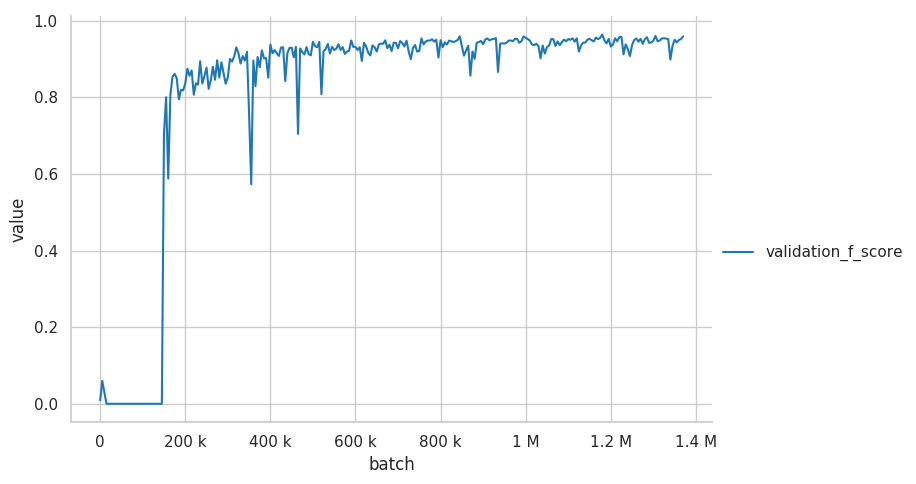

In [326]:
plot_var_lists([validation_f_score], ['validation_f_score'], 
               [val_interval*batch_size], 
               title=None, ylimit=None)

In [18]:
len(validation_f_score)*val_interval/4000

13.75

In [183]:
# find the saved model with highest val F score
i = 0
saved_model_val_list = []
while i<len(validation_f_score2):
    saved_model_val_list.append(validation_f_score2[int(i)])
    i += batch_num_epoch2 / val_interval2
    
print(saved_model_val_list)
print(max(saved_model_val_list))
print('the number in the model name with highest val f score:', saved_model_val_list.index(max(saved_model_val_list))-1)

[0.009117094799876213, 0.0, 0.852521538734436, 0.9712417125701904, 0.9632697701454163, 0.9714558720588684, 0.9848081469535828, 0.9677253365516663, 0.9872958064079285, 0.987910270690918, 0.9909412264823914, 0.9906190633773804, 0.9715162515640259]
0.9909412264823914
the number in the model name with highest val f score: 9


In [21]:
# calculate the corresponding precision and recall of the highest val F score

val_max_index = validation_f_score.index(max(validation_f_score))
vm_num_tp = num_tp[val_max_index]
vm_num_fp = num_fp[val_max_index]
vm_num_fn = num_fn[val_max_index]
vm_precision = vm_num_tp / (vm_num_tp + vm_num_fp)
vm_recall = vm_num_tp / (vm_num_tp + vm_num_fn)
print('max of val f score:', validation_f_score[val_max_index])
print('corresponding precision:', vm_precision)
print('corresponding recall:', vm_recall)

max of val f score: 0.9637595415115356
corresponding precision: 0.9660170892345816
corresponding recall: 0.9615125596726529


In [134]:
# calculate the corresponding precision and recall of the highest val F score

val_max_index2 = validation_f_score2.index(max(validation_f_score2))
vm_num_tp2 = num_tp2[val_max_index2]
vm_num_fp2 = num_fp2[val_max_index2]
vm_num_fn2 = num_fn2[val_max_index2]
vm_precision2 = vm_num_tp2 / (vm_num_tp2 + vm_num_fp2)
vm_recall2 = vm_num_tp2 / (vm_num_tp2 + vm_num_fn2)
print('max of val f score 2:', validation_f_score2[val_max_index2])
print('corresponding precision 2:', vm_precision2)
print('corresponding recall 2:', vm_recall2)

max of val f score 2: 0.9619852304458618
corresponding precision 2: 0.9748788818069255
corresponding recall 2: 0.9494281450404167


In [196]:
2*vm_precision*vm_recall/(vm_precision+vm_recall)

0.9637595610361166

In [219]:
fmri = sns.load_dataset("fmri")
fmri

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970
5,s9,18,stim,parietal,-0.103513
6,s8,18,stim,parietal,-0.064408
7,s7,18,stim,parietal,-0.060526
8,s6,18,stim,parietal,-0.007029
9,s5,18,stim,parietal,-0.040557


In [225]:
a=np.array(validation_f_score)
_x = np.arange(0, 200*len(validation_f_score)*batch_size, 200*batch_size)
print(a.shape)
print(_x.shape)
d={'validation F1 score': a, 'batch':_x}
df = pd.DataFrame(data=d)
df

(275,)
(275,)


,batch,validation F1 score
0,0,0.009075
1,5000,0.059901
2,10000,0.029034
3,15000,0.000015
4,20000,0.000000
5,25000,0.000000
6,30000,0.000000
7,35000,0.000000
8,40000,0.000000
9,45000,0.000000


In [232]:
sns.axes_style()

{'axes.axisbelow': True,
 'axes.edgecolor': '.15',
 'axes.facecolor': 'white',
 'axes.grid': False,
 'axes.labelcolor': '.15',
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'white',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'grid.color': '.8',
 'grid.linestyle': '-',
 'image.cmap': 'rocket',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': '.15',
 'xtick.bottom': True,
 'xtick.color': '.15',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': '.15',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False}

<Figure size 960x720 with 0 Axes>

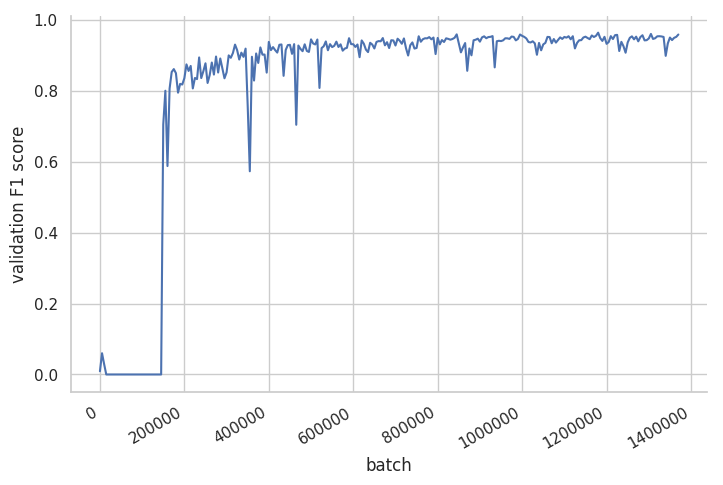

In [257]:
import seaborn as sns; sns.set()
fig = plt.figure(dpi=150)
# sns.set_style("white")
sns.set_context("notebook")
# sns.set_style("darkgrid", {"axes.facecolor": ".9"})
# sns.set_style("ticks")
# sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_style('whitegrid', {'font.family':'sans-serif', 'font.sans-serif':'Arial'})
ax = sns.relplot(x='batch', y='validation F1 score', data=df, kind="line", aspect=1.5)
ax.fig.autofmt_xdate()
# plt.savefig('test_fig', dpi=fig.dpi)
plt.show()

In [251]:
fig


# Previous

all tag types: {'validation_f_score'}
all tag types: {'validation_f_score'}


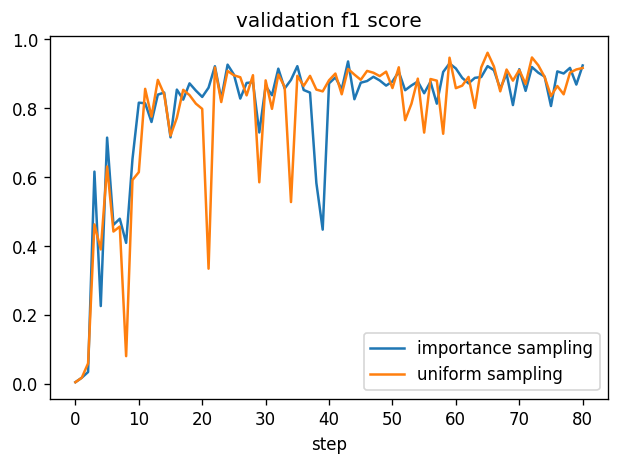

In [113]:
# is_model_path = '/home/stud/zhaoy/local_dir/model_outputs_yi/3DUNet_noPadding_rw:x1.0_l2:0.0_lr:0.0006->0.01_tts:20000_nl:0_nh:0_nd:1_ng:1_bs:18_mg_0.01_csl_60_apa_id_30_06_19_3DUNet_visOnRealOnly_combineSoilWithIntensity6_alsoTrainOnAugmentedData_randomScaling_importanceSampling_lr0.0006/runs'
# us_model_path = '/home/stud/zhaoy/local_dir/model_outputs_yi/3DUNet_noPadding_rw:x1.0_l2:0.0_lr:0.0006->0.01_tts:20000_nl:0_nh:0_nd:1_ng:1_bs:18_mg_0.01_csl_60_apa_id_30_06_19_3DUNet_visOnRealOnly_combineSoilWithIntensity6_alsoTrainOnAugmentedData_randomScaling_uniformSampling_lr0.0006/runs'
is_model_path = '/home/stud/zhaoy/local_dir/model_outputs_yi/3DUNet_noPadding_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:20000_nl:0_nh:0_nd:1_ng:1_bs:18_mg_0.01_csl_60_apa_id_03_07_19_3DUNet_visOnRealOnly_combineSoilWithIntensity6_alsoTrainOnAugmentedData_randomScaling_importanceSampling_lr0.0001/runs'
us_model_path = '/home/stud/zhaoy/local_dir/model_outputs_yi/3DUNet_noPadding_rw:x1.0_l2:0.0_lr:0.0001->0.01_tts:20000_nl:0_nh:0_nd:1_ng:1_bs:18_mg_0.01_csl_60_apa_id_03_07_19_3DUNet_visOnRealOnly_combineSoilWithIntensity6_alsoTrainOnAugmentedData_randomScaling_uniformSampling_lr0.0001/runs'

is_val_f1_path = join(is_model_path, 'events.out.tfevents.1561896248.bigcuda4')
us_val_f1_path = join(us_model_path, 'events.out.tfevents.1561896196.bigcuda4')

is_val_f1_list=get_tag_list(is_val_f1_path)
us_val_f1_list=get_tag_list(us_val_f1_path)

plt.figure(dpi=120)
plt.xlabel('step')
plt.title('validation f1 score')
plt.plot(is_val_f1_list, label='importance sampling')
plt.plot(us_val_f1_list, label='uniform sampling')
plt.legend()
plt.show()


all tag types: {'Regularized_train_losses'}
all tag types: {'Regularized_train_losses'}


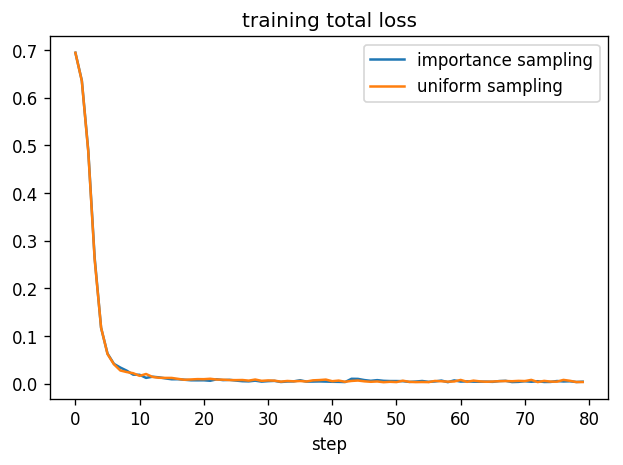

In [112]:
is_train_loss_dir = join(is_model_path, 'Regularized_train_losses/Total loss')
us_train_loss_dir = join(us_model_path, 'Regularized_train_losses/Total loss')
 
is_train_loss_path = get_event_file_path(is_train_loss_dir)
us_train_loss_path = get_event_file_path(us_train_loss_dir)

is_train_loss_list = get_tag_list(is_train_loss_path)
us_train_loss_list = get_tag_list(us_train_loss_path)

plt.figure(dpi=120)
plt.xlabel('step')
plt.title('training total loss')
plt.plot(is_train_loss_list, label='importance sampling')
plt.plot(us_train_loss_list, label='uniform sampling')
plt.legend()
plt.show()


all tag types: {'Regularized_train_losses'}
all tag types: {'Regularized_train_losses'}


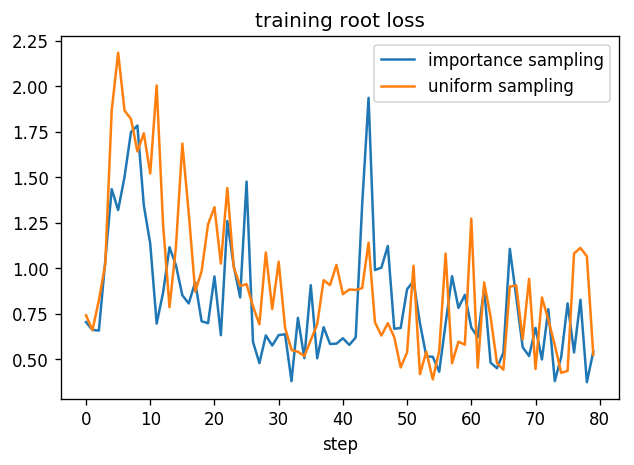

In [111]:
is_train_root_loss_dir = join(is_model_path, 'Regularized_train_losses/Root loss')
us_train_root_loss_dir = join(us_model_path, 'Regularized_train_losses/Root loss')
 
is_train_root_loss_path = get_event_file_path(is_train_root_loss_dir)
us_train_root_loss_path = get_event_file_path(us_train_root_loss_dir)

is_train_root_loss_list = get_tag_list(is_train_root_loss_path)
us_train_root_loss_list = get_tag_list(us_train_root_loss_path)

plt.figure(dpi=120)
plt.xlabel('step')
plt.title('training root loss')
plt.plot(is_train_root_loss_list, label='importance sampling')
plt.plot(us_train_root_loss_list, label='uniform sampling')
plt.legend()
plt.show()


all tag types: {'Regularized_validation_losses'}
all tag types: {'Regularized_validation_losses'}


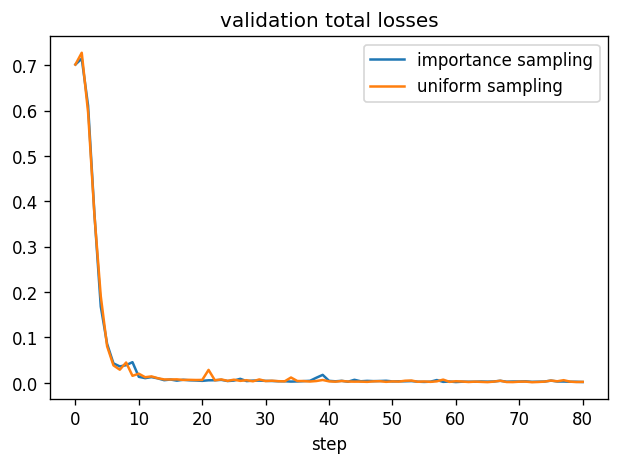

In [118]:
is_dir = join(is_model_path, 'Regularized_validation_losses/Total loss')
us_dir = join(us_model_path, 'Regularized_validation_losses/Total loss')

is_list = get_tag_list(get_event_file_path(is_dir))
us_list = get_tag_list(get_event_file_path(us_dir))

plt.figure(dpi=120)
plt.xlabel('step')
plt.title('validation total losses')
plt.plot(is_list, label='importance sampling')
plt.plot(us_list, label='uniform sampling')
plt.legend()
plt.show()

all tag types: {'Regularized_validation_losses'}
all tag types: {'Regularized_validation_losses'}


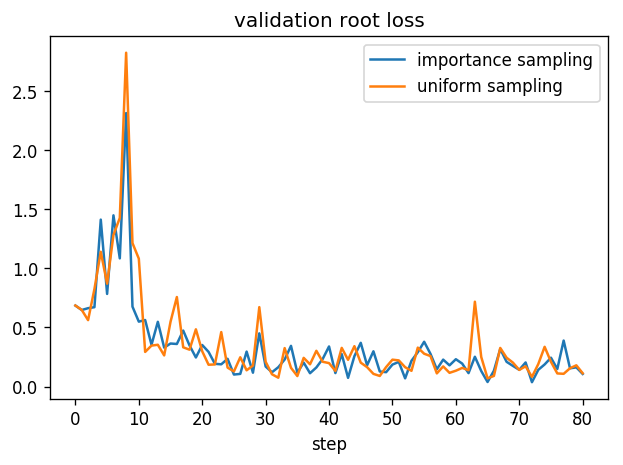

In [119]:
is_dir = join(is_model_path, 'Regularized_validation_losses/Root loss')
us_dir = join(us_model_path, 'Regularized_validation_losses/Root loss')

is_list = get_tag_list(get_event_file_path(is_dir))
us_list = get_tag_list(get_event_file_path(us_dir))

plt.figure(dpi=120)
plt.xlabel('step')
plt.title('validation root loss')
plt.plot(is_list, label='importance sampling')
plt.plot(us_list, label='uniform sampling')
plt.legend()
plt.show()

all tag types: {'Regularized_train_losses'}
all tag types: {'Regularized_validation_losses'}
all tag types: {'Regularized_train_losses'}
all tag types: {'Regularized_validation_losses'}


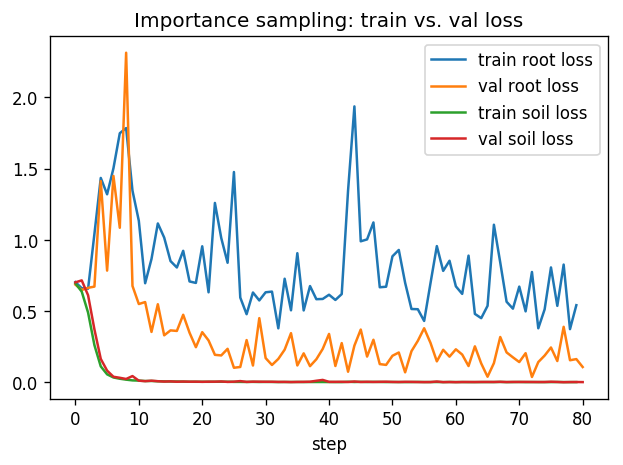

In [120]:
train_root_dir = join(is_model_path, 'Regularized_train_losses/Root loss')
val_root_dir = join(is_model_path, 'Regularized_validation_losses/Root loss')
train_soil_dir = join(is_model_path, 'Regularized_train_losses/Soil loss')
val_soil_dir = join(is_model_path, 'Regularized_validation_losses/Soil loss')

train_root_list = get_tag_list(get_event_file_path(train_root_dir))
val_root_list = get_tag_list(get_event_file_path(val_root_dir))
train_soil_list = get_tag_list(get_event_file_path(train_soil_dir))
val_soil_list = get_tag_list(get_event_file_path(val_soil_dir))

plt.figure(dpi=120)
plt.xlabel('step')
plt.title('Importance sampling: train vs. val loss')
plt.plot(train_root_list, label='train root loss')
plt.plot(val_root_list, label='val root loss')
plt.plot(train_soil_list, label='train soil loss')
plt.plot(val_soil_list, label='val soil loss')
plt.legend()
plt.show()

all tag types: {'Regularized_train_losses'}
all tag types: {'Regularized_validation_losses'}
all tag types: {'Regularized_train_losses'}
all tag types: {'Regularized_validation_losses'}


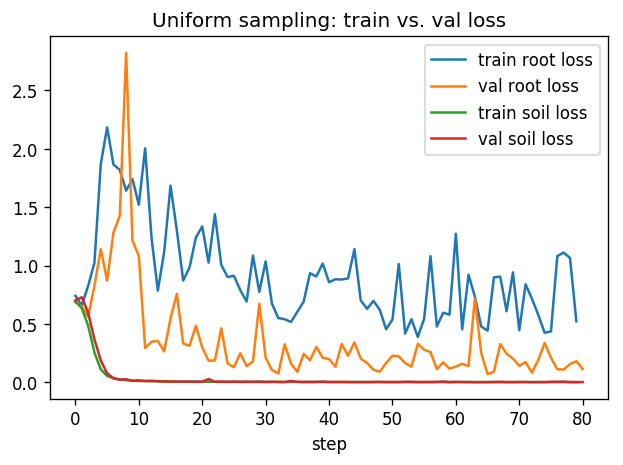

In [121]:
train_root_dir = join(us_model_path, 'Regularized_train_losses/Root loss')
val_root_dir = join(us_model_path, 'Regularized_validation_losses/Root loss')
train_soil_dir = join(us_model_path, 'Regularized_train_losses/Soil loss')
val_soil_dir = join(us_model_path, 'Regularized_validation_losses/Soil loss')

train_root_list = get_tag_list(get_event_file_path(train_root_dir))
val_root_list = get_tag_list(get_event_file_path(val_root_dir))
train_soil_list = get_tag_list(get_event_file_path(train_soil_dir))
val_soil_list = get_tag_list(get_event_file_path(val_soil_dir))

plt.figure(dpi=120)
plt.xlabel('step')
plt.title('Uniform sampling: train vs. val loss')
plt.plot(train_root_list, label='train root loss')
plt.plot(val_root_list, label='val root loss')
plt.plot(train_soil_list, label='train soil loss')
plt.plot(val_soil_list, label='val soil loss')
plt.legend()
plt.show()

In [76]:
is_val_f1_list

[0.004094105213880539,
 0.017006080597639084,
 0.03364493325352669,
 0.6154195666313171,
 0.22518296539783478,
 0.7141356468200684,
 0.460898756980896,
 0.4786241054534912,
 0.4086053669452667,
 0.6517888307571411,
 0.8155758380889893,
 0.8139567971229553,
 0.7595915794372559,
 0.8389005661010742,
 0.8449856042861938,
 0.7149723768234253,
 0.8535732626914978,
 0.824384331703186,
 0.8716527819633484,
 0.8506140112876892,
 0.8322745561599731,
 0.8591093420982361,
 0.9213777780532837,
 0.82623690366745,
 0.9260092973709106,
 0.8970724940299988,
 0.8274815678596497,
 0.8729117512702942,
 0.8749129176139832,
 0.7290621995925903,
 0.8642030358314514,
 0.8372563123703003,
 0.9142684936523438,
 0.8566457629203796,
 0.8818657994270325,
 0.9216142892837524,
 0.8523851633071899,
 0.8448359370231628,
 0.5824748277664185,
 0.4469928741455078,
 0.871687650680542,
 0.8889945149421692,
 0.8543434143066406,
 0.9352867007255554,
 0.8256669044494629,
 0.8735605478286743,
 0.8784403204917908,
 0.890749454

In [41]:
for e in tf.train.summary_iterator(event_path):
    print(e.step)
    
    1561896248

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
